# 介紹

初次接觸新數據集有時會讓人感到不知所措。您可能會看到數百或數千個特徵，甚至連描述都沒有。我們該從何開始？

偉大的第一步是使用 **feature Utility metric(特徵效用指標)** 構建等級，該功能用於衡量要素與目標之間的關聯。然後，您可以選擇一組較小的最有用的功能進行初始開發，並更有信心將您的時間花在上面。

我們將使用的衡量標準稱為“相互信息(mutual information)”。相互信息非常類似於相關性，因為它可以測量兩個變量之間的關係。相互信息的優點是它可以檢測*任何*類型的關係，而關聯僅檢測*線性*關係。

相互信息是一種很好的通用指標，在您可能不知道要使用哪種模型的情況下，在特徵開發開始時特別有用。是：

- 易於使用和解釋
- 計算效率高
- 理論上有充分的依據
- 防止過度擬合
- 能夠發現任何類型的關係

# 共同信息及其方法

相互信息用*不確定性*來描述關係。兩個數量之間的**相互信息**（MI）是對一個數量的知識減少對另一個數量的不確定性的程度的度量。如果知道某個特徵的價值，那麼我們對目標會增加多大的信心？

這是來自 *Ames Housing* 數據的示例。該圖顯示了房屋的外部質量與其所售價格之間的關係。每個點代表一棟房子。

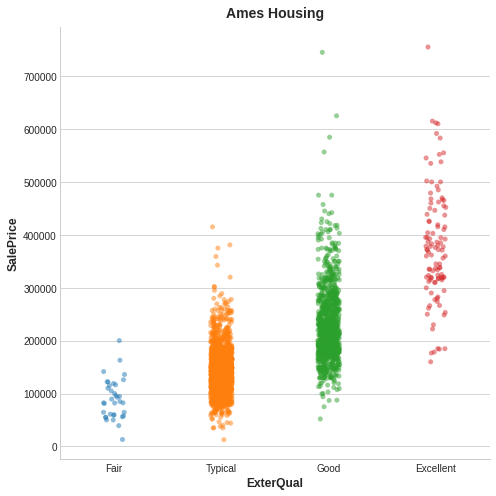

In [2]:
from IPython.display import Image 
Image(filename = "img/L4-2.png")

▲ 了解房屋的外部質量可降低其銷售價格的不確定性。

從圖中可以看出，了解 `ExterQual` 的價值可以使我們對相應的SalePrice更加確定:  `ExterQual` 的每個類別都傾向於將 `SalePrice` 集中在某個範圍內。 `ExterQual` 與 `SalePrice` 的共同信息是，相對於 `ExterQual` 的四個值， `SalePrice` 不確定性的平均降低程度。例如，由於 `Fair` 發生的頻率比 `Typical` 事件少，因此 `Fair` 在 MI得分中的權重降低了。

（技術說明：**不確定性**是使用信息論中稱為“ **熵(Entropy)** ”的值來衡量的。變量的熵大致表示：“平均而言，您需要多少個是或否的問題來描述該問題的發生? 您必須要問的問題越多，您對變量的不確定性就越大。相互信息是我們希望某個特徵能回答(了解)多少有關目標的問題。）

# 解釋相互信息得分

數量(quantity)之間的最小可能互信息為 **0.0** 。當 MI 為零時，數量是獨立的：兩個都無法告訴您任何其他信息。相反，理論上，MI並沒有上限。實際上，儘管高於2.0左右的值並不常見。 （相互信息是對數，因此增加非常緩慢。）

下圖將使您了解 MI值 如何對應於特徵與目標的關聯類型和關聯度。

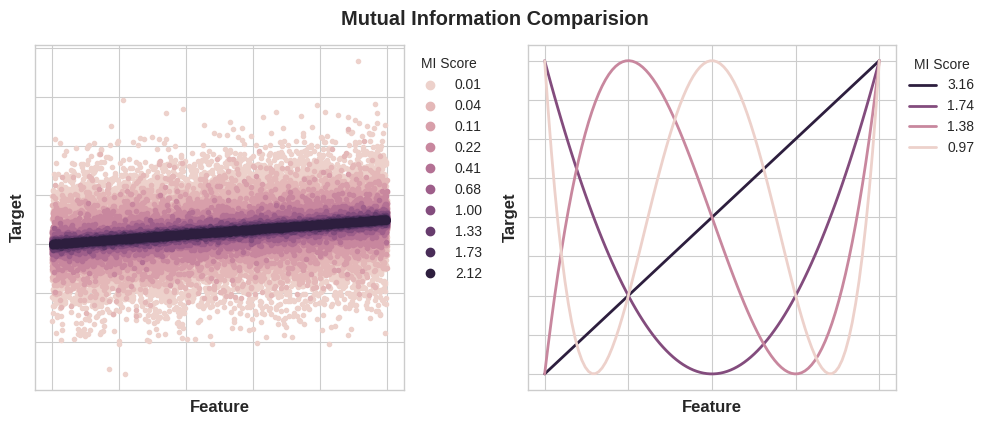

In [3]:
Image(filename = "img/L4-2-1.png")

▲ 左：隨著特徵與目標之間的依賴性越來越緊密，相互信息增加。 <br>
▲ 右：相互信息可以捕獲任何類型的關聯（不僅僅是線性，如關聯）。

應用相互信息時，需要記住以下幾點：

- MI可以幫助我們了解功特徵本身作為目標預測指標的相對潛力。
- 與其他特徵交互時，特徵可能會提供非常豐富的信息，但單獨時可能不會提供足夠的信息。 MI無法檢測特徵之間的交互。 它是單變量(univariate)指標。

- 特徵的實際用途取決於使用它的模型。**特徵僅在其與目標的關係是我們的模型可以學習的範圍內才有用**。 僅僅因為某項特徵具有較高的MI分數，並不意味著您的模型就可以使用該特徵進行任何操作。 您可能需要先轉換特徵以暴露關聯。

# 範例 - 1985 Automobiles

[*汽車數據集*](https://www.kaggle.com/toramky/automobile-dataset)包含1985年中的193輛汽車。 該數據集的目標是根據汽車的23個特徵（例如 `make` , `body_style` , 和  `horsepower` ）來預測汽車的價格（目標）。 在此示例中，我們將使用相互信息對要素進行排名，並通過資料視覺化檢視結果。

以下程式碼將導入一些函式庫並加載數據集。

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("./data_set/Automobile_data.csv")
df.drop([df.columns[1]], axis=1, inplace=True)
df = df[df['price'] != '?']
df.reset_index(drop=True,inplace=True)
df['price'] = pd.to_numeric(df['price'])

df.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


MI的scikit-learn演算法將離散特徵與連續特徵區別對待。 因此，您需要告訴它哪個是哪個。 根據經驗，任何必須具有 `float` dtype的對像都不是離散的。 通過為類別（`object` 或 `categorial` dtype）賦予標籤編碼，可以將它們視為離散的。 （您可以在[分類變量課程](http://www.kaggle.com/alexisbcook/categorical-variables)中查看標籤編碼。）

In [57]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn在其 `feature_selection` 模組中具有兩個相互信息指標：一個用於實值(real-valued)目標（ `mutual_info_regression` ），另一個用於類別目標（ `mutual_info_classif` ）。 我們的目標價格是實際價值。 下一個單元格為我們的功能計算MI分數，並將它們包裝在一個不錯的 dataframe 中。

In [58]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb-weight         0.898866
city-mpg            0.771493
horsepower          0.578304
stroke              0.451768
num-of-cylinders    0.313883
make                0.224238
engine-type         0.161387
fuel-type           0.039196
Name: MI Scores, dtype: float64

現在，一個長條圖使比較更加容易：

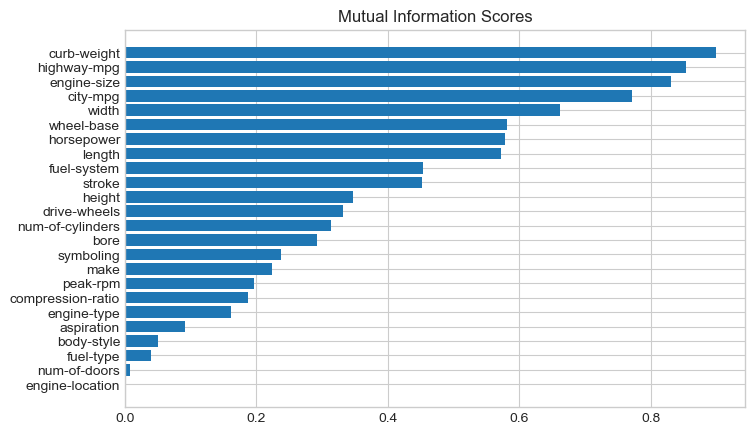

In [59]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

數據視覺化是對實用特徵排名的重要追蹤。 讓我們仔細看看其中的幾個。

如我們所料，高分的 `curb_weight` 特徵與目標價格有著密切的關係。

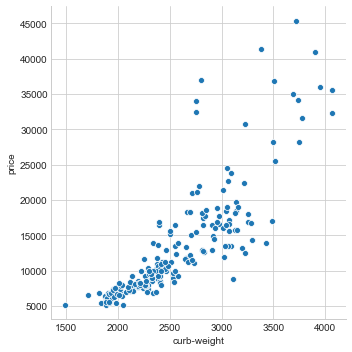

In [60]:
sns.relplot(x="curb-weight", y="price", data=df, kind='scatter');

 `fuel_type` 特徵的MI得分相對較低，但是從圖中可以看出，它清楚地將馬力功能內具有不同趨勢的兩個價格群體分開。 這表明fuel_type會產生交互作用，並且可能並非無關緊要。 在確定某個功能與其MI分數無關緊要之前，最好調查一下任何可能的交互作用: **領域知識** 可以在此處提供很多方向。

數據視覺化是特徵工程的重要手法。 除公用指標（如互信息）外，此類視覺化還可以幫助我們發現數據中的重要關係。 查看kaggle的[數據視覺化課程](https://www.kaggle.com/learn/data-visualization)以了解更多信息！